#  Environment Setup and Library Imports

In [1]:


!pip install -q shap lime imbalanced-learn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE, ADASYN

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout, concatenate
from tensorflow.keras.callbacks import EarlyStopping

import shap
import lime
import lime.lime_tabular

from google.colab import drive
drive.mount('/content/drive')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

np.random.seed(42)
tf.random.set_seed(42)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Mounted at /content/drive


#  Load and Inspect All Dataset Files from Google Drive

Customers:
    Customer ID                 Name                                 Email             Telephone      City        Country Gender Date Of Birth              Job Title
0            1         Tyler Garcia           tyler.garcia@fake_gmail.com    922.970.2265x47563  New York  United States      M    2003-07-15                    NaN
1            2        Joshua Miller          joshua.miller@fake_gmail.com       +1-958-729-6169  New York  United States      M    2000-06-16        Records manager
2            3  Alison Marshall DDS  alison.marshall.dds@fake_hotmail.com  +1-645-567-0876x5409  New York  United States      F    2003-07-22                    NaN
3            4       Jeffery Acosta         jeffery.acosta@fake_yahoo.com    212.336.0912x84994  New York  United States      M    1996-11-12            Proofreader
4            5       Ashley Sanders       ashley.sanders@fake_hotmail.com            7814535781  New York  United States      F    1998-02-10  Exercise physiologis

<ipython-input-2-5b75be4980cf>:29: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:29: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


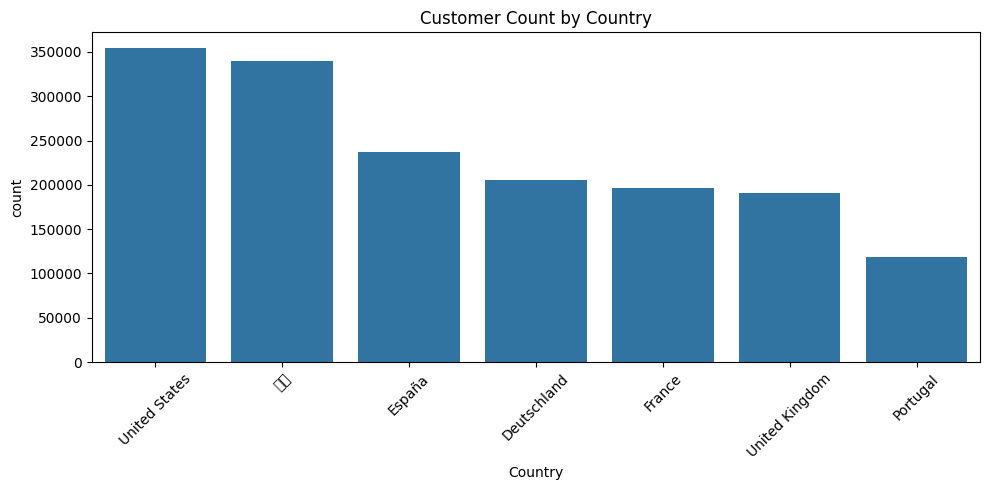

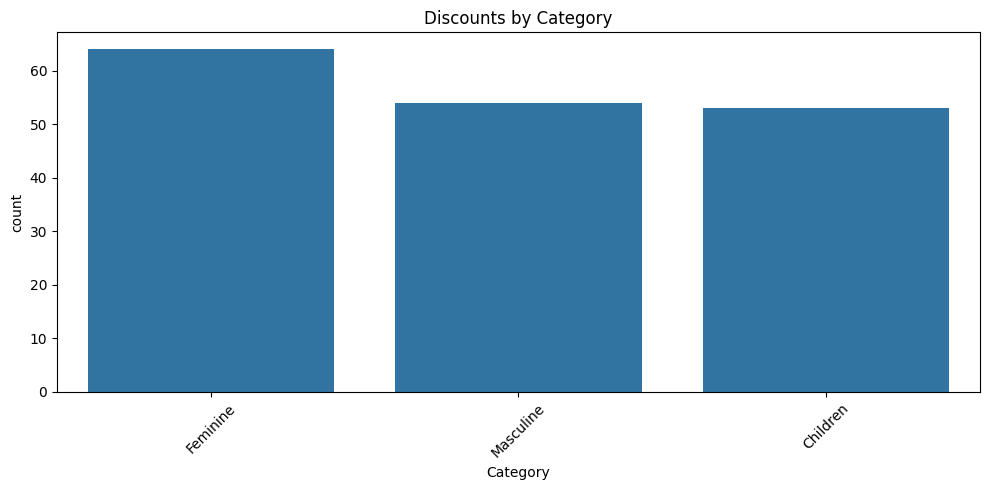

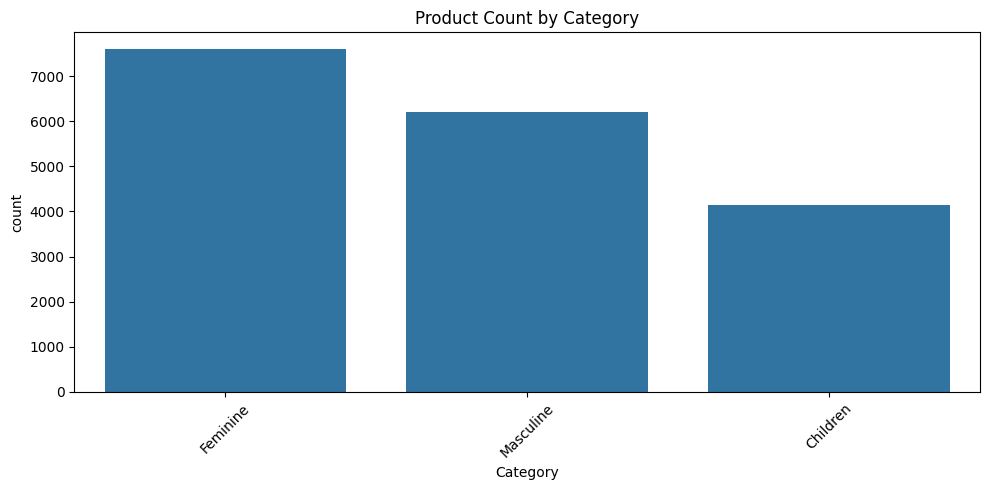

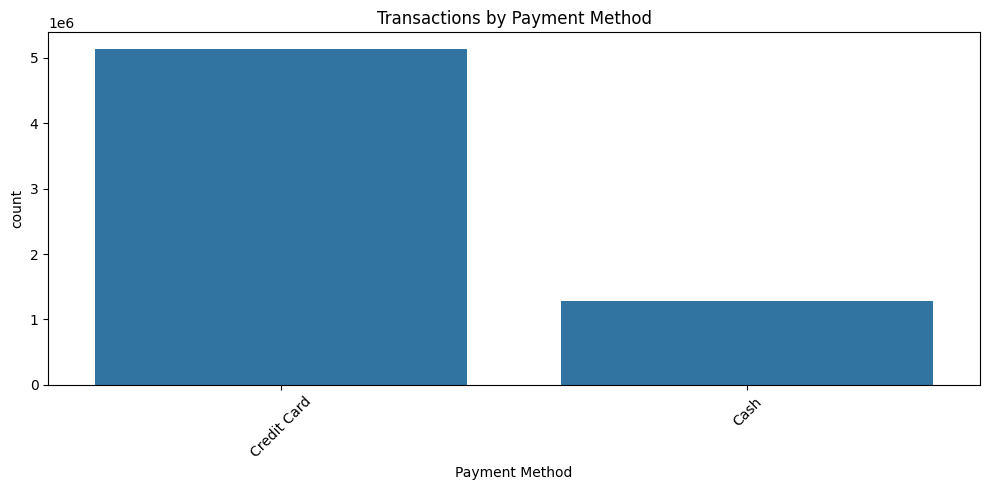

<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 28023 (\N{CJK UNIFIED IDEOGRAPH-6D77}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 21271 (\N{CJK UNIFIED IDEOGRAPH-5317}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 20140 (\N{CJK UNIFIED IDEOGRAPH-4EAC}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 24191 (\N{CJK UNIFIED IDEOGRAPH-5E7F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 24030 (\N{CJK UNIFIED IDEOGRAPH-5DDE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-2-5b75be4980cf>:56: UserWarning: Glyph 28145 (\N{CJK UNIFIED IDEOGRAPH-6DF1}) missing from font(s

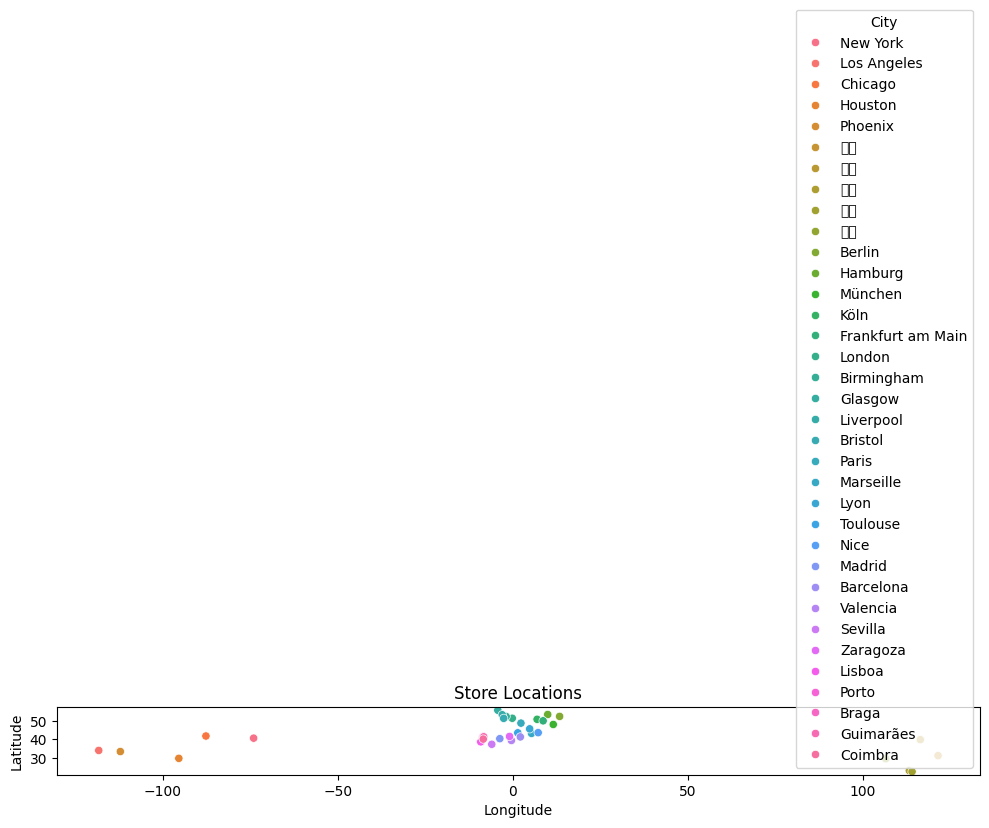

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


base_path = '/content/drive/MyDrive'

customers = pd.read_csv(os.path.join(base_path, 'customers.csv'), low_memory=False)
discounts = pd.read_csv(os.path.join(base_path, 'discounts.csv'), low_memory=False)
employees = pd.read_csv(os.path.join(base_path, 'employees.csv'), low_memory=False)
products = pd.read_csv(os.path.join(base_path, 'products.csv'), low_memory=False)
stores = pd.read_csv(os.path.join(base_path, 'stores.csv'), low_memory=False)
transactions = pd.read_csv(os.path.join(base_path, 'transactions.csv'), low_memory=False)

# Display first 5 rows of each dataset
print("Customers:\n", customers.head(), "\n")
print("Discounts:\n", discounts.head(), "\n")
print("Employees:\n", employees.head(), "\n")
print("Products:\n", products.head(), "\n")
print("Stores:\n", stores.head(), "\n")
print("Transactions:\n", transactions.head(), "\n")

# Visualizations
plt.figure(figsize=(10, 5))
sns.countplot(data=customers, x='Country', order=customers['Country'].value_counts().index)
plt.title('Customer Count by Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=discounts, x='Category', order=discounts['Category'].value_counts().index)
plt.title('Discounts by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=products, x='Category', order=products['Category'].value_counts().index)
plt.title('Product Count by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(data=transactions, x='Payment Method', order=transactions['Payment Method'].value_counts().index)
plt.title('Transactions by Payment Method')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.scatterplot(data=stores, x='Longitude', y='Latitude', hue='City')
plt.title('Store Locations')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os


base_path = '/content/drive/MyDrive'

# Load all CSVs using full paths
customers = pd.read_csv(os.path.join(base_path, 'customers.csv'), low_memory=False)
discounts = pd.read_csv(os.path.join(base_path, 'discounts.csv'), low_memory=False)
employees = pd.read_csv(os.path.join(base_path, 'employees.csv'), low_memory=False)
products = pd.read_csv(os.path.join(base_path, 'products.csv'), low_memory=False)
stores = pd.read_csv(os.path.join(base_path, 'stores.csv'), low_memory=False)
transactions = pd.read_csv(os.path.join(base_path, 'transactions.csv'), low_memory=False)


# Quick inspection of data
print("Customers:", customers.shape)
print("Transactions:", transactions.shape)
print("Products:", products.shape)
print("Discounts:", discounts.shape)
print("Employees:", employees.shape)
print("Stores:", stores.shape)


Customers: (1643306, 9)
Transactions: (6416827, 19)
Products: (17940, 12)
Discounts: (181, 6)
Employees: (404, 4)
Stores: (35, 8)


# Data Preprocessing and Feature Engineering

In [4]:
from datetime import datetime, timedelta


# Convert transaction date to datetime
transactions['Date'] = pd.to_datetime(transactions['Date'])

# Merge transactions with products to get category information
trans_prod = pd.merge(transactions, products, how='left', on='Product ID')

# Create discount usage flag (assuming Discount column is a decimal)
trans_prod['used_discount'] = trans_prod['Discount'].apply(lambda x: 1 if x > 0 else 0)

# Aggregate transaction data per customer
agg_funcs = {
    'Unit Price': 'sum',                   # total spend
    'Product ID': 'count',                 # number of transactions
    'used_discount': 'sum',                # how many discounted purchases
    'Category': pd.Series.nunique,         # diversity of categories
    'Date': ['min', 'max']                 # first and last transaction
}
cust_agg = trans_prod.groupby('Customer ID').agg(agg_funcs)
cust_agg.columns = ['total_spend', 'purchase_count', 'discount_count', 'distinct_categories',
                    'first_purchase_date', 'last_purchase_date']
cust_agg = cust_agg.reset_index()

# Merge with customers.csv data
customer_features = pd.merge(customers, cust_agg, how='left', left_on='Customer ID', right_on='Customer ID')

# Calculate recency and tenure
if customer_features['last_purchase_date'].notna().any():
    current_date = customer_features['last_purchase_date'].max() + pd.Timedelta(days=1)
else:
    current_date = datetime.today()

min_date = transactions['Date'].min()
customer_features['last_purchase_date'] = customer_features['last_purchase_date'].fillna(min_date - pd.Timedelta(days=1))
customer_features['first_purchase_date'] = customer_features['first_purchase_date'].fillna(min_date - pd.Timedelta(days=1))

customer_features['recency_days'] = (current_date - customer_features['last_purchase_date']).dt.days
customer_features['tenure_days'] = (customer_features['last_purchase_date'] - customer_features['first_purchase_date']).dt.days

# Compute average spend and discount ratio
customer_features['avg_spend'] = customer_features['total_spend'] / customer_features['purchase_count']
customer_features['avg_spend'] = customer_features['avg_spend'].fillna(0)

customer_features['discount_ratio'] = customer_features['discount_count'] / customer_features['purchase_count']
customer_features['discount_ratio'] = customer_features['discount_ratio'].fillna(0)

# Generate 12-month time series of purchases
end_date = current_date - pd.Timedelta(days=1)
start_date = end_date - pd.DateOffset(months=12)

# Filter last 12 months of data
last_year_trans = trans_prod[(trans_prod['Date'] >= start_date) & (trans_prod['Date'] <= end_date)]
last_year_trans['Month'] = last_year_trans['Date'].dt.to_period('M')

# Count purchases per customer per month
monthly_counts = last_year_trans.groupby(['Customer ID', 'Month']).size().reset_index(name='purchases')

# Generate full month list for 12 months
month_list = [(start_date + pd.DateOffset(months=i)).to_period('M') for i in range(12)]

# Pivot to wide format (1 row per customer, 1 column per month)
monthly_counts_pivot = monthly_counts.pivot(index='Customer ID', columns='Month', values='purchases').reindex(columns=month_list, fill_value=0)
monthly_counts_pivot = monthly_counts_pivot.reindex(customer_features['Customer ID'], fill_value=0)
monthly_counts_pivot.columns = [str(col) for col in monthly_counts_pivot.columns]
monthly_counts_pivot.reset_index(inplace=True)

# Merge sequence data into customer_features
customer_features = pd.merge(customer_features, monthly_counts_pivot, how='left', on='Customer ID')

# Label churn based on recency threshold
churn_threshold_days = 30  # can be 7 or 1 for weekly/daily
customer_features['churn_label'] = (customer_features['recency_days'] > churn_threshold_days).astype(int)

# Final feature set
feature_cols = ['Customer ID', 'recency_days', 'purchase_count', 'total_spend', 'avg_spend',
                'discount_count', 'discount_ratio', 'distinct_categories', 'tenure_days']
feature_cols += [str(m) for m in month_list]  # add 12-month sequence columns

# Preview
print("Feature columns:", feature_cols)
print(customer_features[feature_cols + ['churn_label']].head(3))


<ipython-input-4-548cdc564d3f>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_year_trans['Month'] = last_year_trans['Date'].dt.to_period('M')


Feature columns: ['Customer ID', 'recency_days', 'purchase_count', 'total_spend', 'avg_spend', 'discount_count', 'discount_ratio', 'distinct_categories', 'tenure_days', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02']
   Customer ID  recency_days  purchase_count  total_spend  avg_spend  discount_count  discount_ratio  distinct_categories  tenure_days  2024-03  2024-04  2024-05  2024-06  2024-07  2024-08  2024-09  \
0            1           102             8.0        264.5    33.0625             1.0           0.125                  3.0          307      1.0      NaN      1.0      NaN      NaN      NaN      NaN   
1            2            34            10.0        506.5    50.6500             3.0           0.300                  3.0          643      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
2            3           297             3.0        136.5    45.5000             0.0           0

# Defining Churn and Labeling the Data

In [5]:
# Define churn threshold (configurable)
churn_mode = 'monthly'  # options: 'daily', 'weekly', 'monthly'
if churn_mode == 'daily':
    churn_threshold_days = 1   # e.g., if no purchase in 1 day (not very applicable for retail, but for demonstration)
elif churn_mode == 'weekly':
    churn_threshold_days = 7   # 1 week threshold
else:  # 'monthly'
    churn_threshold_days = 30  # 30 days threshold for churn

# Label churn: 1 if recency_days > threshold, else 0
customer_features['churn_label'] = (customer_features['recency_days'] > churn_threshold_days).astype(int)

# Check class distribution
counts = customer_features['churn_label'].value_counts()
print("Churn label distribution:")
print(f"Not churn (0): {counts.get(0,0)}")
print(f"Churn (1): {counts.get(1,0)}")


Churn label distribution:
Not churn (0): 124531
Churn (1): 1518775


# Handling Class Imbalance with SMOTE and ADASYN

In [6]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import StandardScaler

# Select feature columns for modeling
# Static features we will use (some are highly correlated, but we'll include a broad set)
static_feats = ['recency_days', 'purchase_count', 'total_spend', 'avg_spend', 'discount_ratio', 'distinct_categories', 'tenure_days']
# Sequence features: the monthly purchase counts (12 months)
seq_feats = [str(m) for m in month_list]  # month_list was defined in feature engineering

# Create feature matrix X and target vector y
X = customer_features[static_feats + seq_feats].fillna(0).values  # fillna in case of any missing
y = customer_features['churn_label'].values

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train churn proportion:", np.mean(y_train), "Test churn proportion:", np.mean(y_test))

# Feature scaling: scale features for better model performance (using StandardScaler on train data only)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to the training data (to address class imbalance)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE oversampling: train size", X_train_res.shape, "churn proportion:", np.mean(y_train_res).round(2))

# (Optional) ADASYN could be used similarly:
# adasyn = ADASYN(random_state=42)
# X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)

# Separate the oversampled features back into static and sequence for model input
# Remember: static_feats + seq_feats were concatenated in X
n_static = len(static_feats)
n_seq = len(seq_feats)
# Sequence features were 12 monthly counts
seq_length = n_seq  # should be 12
seq_feat_count = 1  # we have 1 feature (purchase count) per month in this sequence
# Actually we have just the count per month as sequence feature. If needed, we could treat each month count as one feature.
# But to use with e.g. LSTM which expects a 2D feature per time step, we'll reshape to (seq_length, 1).

# Reshape sequence part to (samples, 12, 1)
X_train_seq = X_train_res[:, n_static:].reshape(-1, seq_length, 1)
X_train_static = X_train_res[:, :n_static]
X_test_seq = X_test[:, n_static:].reshape(-1, seq_length, 1)
X_test_static = X_test[:, :n_static]

print("Oversampled train sequence shape:", X_train_seq.shape, "static shape:", X_train_static.shape)


Train size: (1314644, 19) Test size: (328662, 19)
Train churn proportion: 0.9242190281171176 Test churn proportion: 0.9242200193511876
After SMOTE oversampling: train size (2430038, 19) churn proportion: 0.5
Oversampled train sequence shape: (2430038, 12, 1) static shape: (2430038, 7)


# Model 1: CNN (Convolutional Neural Network) for Churn Prediction

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Flatten

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define CNN model architecture
seq_input = Input(shape=(seq_length, 1), name='sequence_input')  # sequence of length 12
static_input = Input(shape=(len(static_feats),), name='static_input')  # static feature vector

# Convolutional layers for sequence processing
x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(seq_input)
x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
# Global max pooling to get the most salient signals
x = GlobalMaxPooling1D()(x)
# Alternatively, we could use Flatten() to retain all filter outputs.

# Concatenate pooled features with static features
combined = Concatenate()([x, static_input])
# Dense layers on combined features
combined = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)  # sigmoid output for churn probability

model_cnn = Model(inputs=[seq_input, static_input], outputs=output)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
model_cnn.summary()

# Train the CNN model
history_cnn = model_cnn.fit([X_train_seq, X_train_static], y_train_res, epochs=10, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate on test set
cnn_results = model_cnn.evaluate([X_test_seq, X_test_static], y_test, verbose=0)
print(f"\nCNN Test Performance: Loss={cnn_results[0]:.4f}, Accuracy={cnn_results[1]:.4f}, Precision={cnn_results[2]:.4f}, Recall={cnn_results[3]:.4f}, AUC={cnn_results[4]:.4f}")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 12, 16)    │         64 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 12, 16)    │        784 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 16)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 23)        │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        768 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,649 (6.44 KB)

 Trainable params: 1,649 (6.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 189s 3ms/step - accuracy: 0.9765 - auc: 0.9950 - loss: 0.0675 - precision: 0.9904 - recall: 0.9670 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0026 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 186s 3ms/step - accuracy: 0.9949 - auc: 0.9998 - loss: 0.0144 - precision: 0.9987 - recall: 0.9921 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0022 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 186s 3ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0110 - precision: 0.9989 - recall: 0.9940 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 186s 3ms/step - accuracy: 0.9965 - auc: 0.9999 - loss: 0.0096 - precision: 0.9988 - recall: 0.9950 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0014 - val_precisi

# Model 2: LSTM (Long Short-Term Memory Network) for Churn Prediction

In [9]:
 import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

# Force GPU usage (optional, TensorFlow does this by default if GPU is available)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # prevent memory allocation issues
        print("GPU is available and configured.")
    except RuntimeError as e:
        print(e)

# Define LSTM model architecture
seq_input = Input(shape=(seq_length, 1), name='sequence_input')
static_input = Input(shape=(len(static_feats),), name='static_input')

# LSTM layer for sequence
x = LSTM(32, activation='tanh')(seq_input)

# Concatenate with static features
combined = Concatenate()([x, static_input])
combined = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)

# Build and compile model
model_lstm = Model(inputs=[seq_input, static_input], outputs=output)
model_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model_lstm.summary()

# Train the LSTM model (runs on GPU if available)
history_lstm = model_lstm.fit(
    [X_train_seq, X_train_static], y_train_res,
    epochs=5,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate on test set
lstm_results = model_lstm.evaluate([X_test_seq, X_test_static], y_test, verbose=0)
print(f"\nLSTM Test Performance: Loss={lstm_results[0]:.4f}, Accuracy={lstm_results[1]:.4f}, "
      f"Precision={lstm_results[2]:.4f}, Recall={lstm_results[3]:.4f}, AUC={lstm_results[4]:.4f}")


Physical devices cannot be modified after being initialized


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │      4,352 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 39)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      1,280 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         33 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,665 (22.13 KB)

 Trainable params: 5,665 (22.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 424s 6ms/step - accuracy: 0.9790 - auc: 0.9956 - loss: 0.0626 - precision: 0.9905 - recall: 0.9717 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0025 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 419s 6ms/step - accuracy: 0.9959 - auc: 0.9999 - loss: 0.0119 - precision: 0.9992 - recall: 0.9933 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0017 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 421s 6ms/step - accuracy: 0.9959 - auc: 0.9999 - loss: 0.0122 - precision: 0.9989 - recall: 0.9937 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 424s 6ms/step - accuracy: 0.9959 - auc: 0.9999 - loss: 0.0114 - precision: 0.9987 - recall: 0.9940 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0011 - val_precision: 

# Model 3: Transformer (Self-Attention) for Churn Prediction

In [10]:
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D

# Define Transformer model architecture (simplified)
seq_input = Input(shape=(seq_length, 1), name='sequence_input')
static_input = Input(shape=(len(static_feats),), name='static_input')

# Project the 1-d sequence values into a higher-d feature space for the transformer
embed_dim = 16
proj = Dense(embed_dim, activation='relu', name='seq_embed')(seq_input)  # project each time step to 16-dim

# Multi-head self-attention
attn_layer = MultiHeadAttention(num_heads=4, key_dim=4, name='mha')
attn_output = attn_layer(proj, proj, proj)  # self-attention: query, key, value all from proj
# Note: Using one attention layer; for a deeper transformer, we'd add normalization, feed-forward, etc.

# Global average pooling over time dimension (could also use [CLS] token approach or max pooling)
attn_pooled = GlobalAveragePooling1D()(attn_output)

# Concatenate with static features
combined = Concatenate()([attn_pooled, static_input])
combined = Dense(32, activation='relu')(combined)
output = Dense(1, activation='sigmoid')(combined)

model_trans = Model(inputs=[seq_input, static_input], outputs=output)
model_trans.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')])
model_trans.summary()

# Train the Transformer model
history_trans = model_trans.fit([X_train_seq, X_train_static], y_train_res, epochs=5, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate on test set
trans_results = model_trans.evaluate([X_test_seq, X_test_static], y_test, verbose=0)
print(f"\nTransformer Test Performance: Loss={trans_results[0]:.4f}, Accuracy={trans_results[1]:.4f}, Precision={trans_results[2]:.4f}, Recall={trans_results[3]:.4f}, AUC={trans_results[4]:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence_input      │ (None, 12, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_embed (Dense)   │ (None, 12, 16)    │         32 │ sequence_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 12, 16)    │      1,088 │ seq_embed[0][0],  │
│ (MultiHeadAttentio… │                   │            │ seq_embed[0][0],  │
│                     │                   │            │ seq_embed[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ mha[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 23)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 32)        │        768 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,921 (7.50 KB)

 Trainable params: 1,921 (7.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 203s 3ms/step - accuracy: 0.9755 - auc: 0.9959 - loss: 0.0696 - precision: 0.9939 - recall: 0.9615 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0021 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 193s 3ms/step - accuracy: 0.9951 - auc: 0.9999 - loss: 0.0142 - precision: 0.9988 - recall: 0.9924 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 194s 3ms/step - accuracy: 0.9961 - auc: 0.9999 - loss: 0.0109 - precision: 0.9988 - recall: 0.9941 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0018 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
68345/68345 ━━━━━━━━━━━━━━━━━━━━ 195s 3ms/step - accuracy: 0.9966 - auc: 0.9999 - loss: 0.0094 - precision: 0.9988 - recall: 0.9950 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0014 - val_precision: 

# Performance Comparison and Confusion Matrix

10271/10271 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step
10271/10271 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step
10271/10271 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


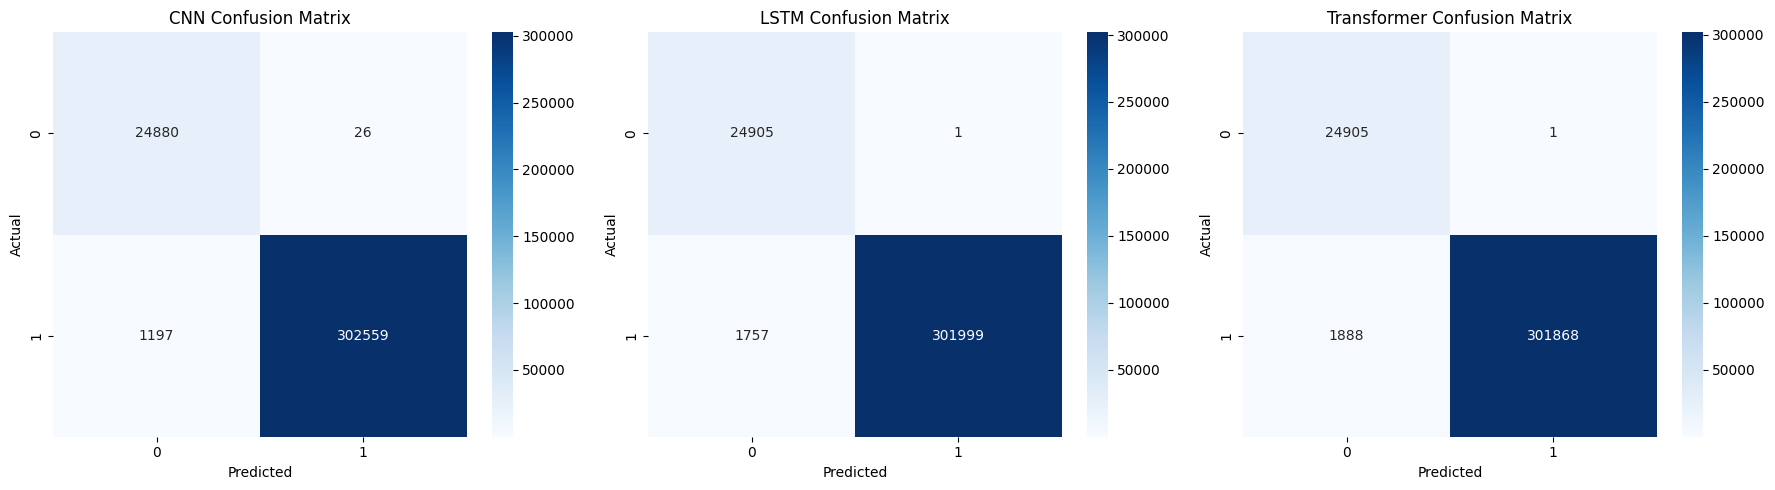


CNN Classification Report:

              precision    recall  f1-score   support

           0     0.9541    0.9990    0.9760     24906
           1     0.9999    0.9961    0.9980    303756

    accuracy                         0.9963    328662
   macro avg     0.9770    0.9975    0.9870    328662
weighted avg     0.9964    0.9963    0.9963    328662


LSTM Classification Report:

              precision    recall  f1-score   support

           0     0.9341    1.0000    0.9659     24906
           1     1.0000    0.9942    0.9971    303756

    accuracy                         0.9947    328662
   macro avg     0.9670    0.9971    0.9815    328662
weighted avg     0.9950    0.9947    0.9947    328662


Transformer Classification Report:

              precision    recall  f1-score   support

           0     0.9295    1.0000    0.9635     24906
           1     1.0000    0.9938    0.9969    303756

    accuracy                         0.9943    328662
   macro avg     0.9648    0.996

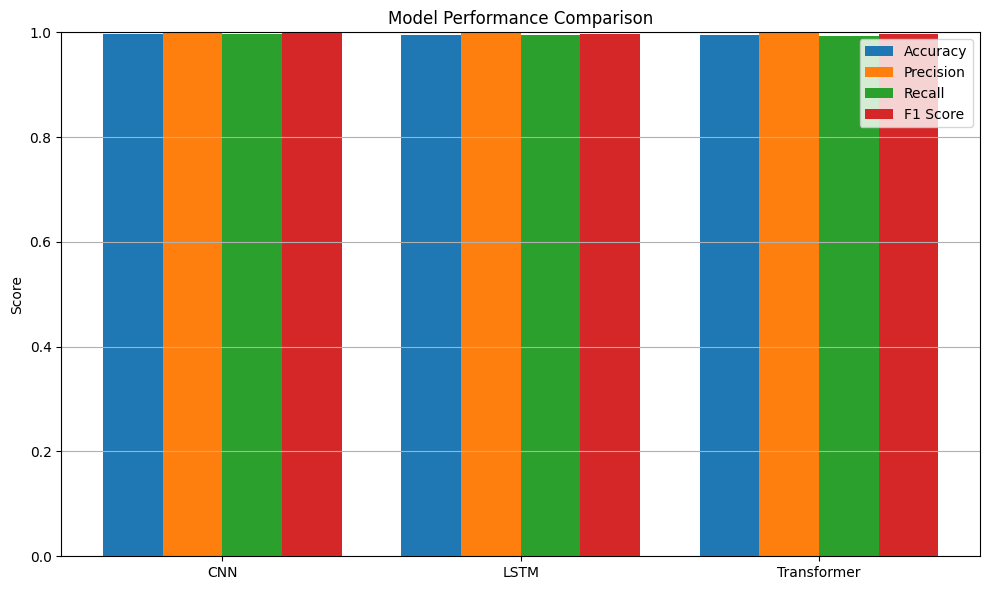

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

# Predict probabilities
y_pred_cnn = model_cnn.predict([X_test_seq, X_test_static]).flatten()
y_pred_lstm = model_lstm.predict([X_test_seq, X_test_static]).flatten()
y_pred_trans = model_trans.predict([X_test_seq, X_test_static]).flatten()

# Convert probabilities to labels
y_pred_cnn_label = (y_pred_cnn >= 0.5).astype(int)
y_pred_lstm_label = (y_pred_lstm >= 0.5).astype(int)
y_pred_trans_label = (y_pred_trans >= 0.5).astype(int)

# Confusion matrices
cm_cnn = confusion_matrix(y_test, y_pred_cnn_label)
cm_lstm = confusion_matrix(y_test, y_pred_lstm_label)
cm_trans = confusion_matrix(y_test, y_pred_trans_label)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
model_names = ['CNN', 'LSTM', 'Transformer']
cms = [cm_cnn, cm_lstm, cm_trans]

for ax, cm, name in zip(axes, cms, model_names):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Classification reports and metric comparison
metrics = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': []}

for name, y_pred in zip(model_names, [y_pred_cnn_label, y_pred_lstm_label, y_pred_trans_label]):
    metrics['Model'].append(name)
    metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['Precision'].append(precision_score(y_test, y_pred, zero_division=0))
    metrics['Recall'].append(recall_score(y_test, y_pred))
    metrics['F1 Score'].append(f1_score(y_test, y_pred))
    print(f"\n{name} Classification Report:\n")
    print(classification_report(y_test, y_pred, digits=4))

# Create performance comparison plot
plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
width = 0.2

plt.bar(x - 1.5*width, metrics['Accuracy'], width, label='Accuracy')
plt.bar(x - 0.5*width, metrics['Precision'], width, label='Precision')
plt.bar(x + 0.5*width, metrics['Recall'], width, label='Recall')
plt.bar(x + 1.5*width, metrics['F1 Score'], width, label='F1 Score')

plt.xticks(x, metrics['Model'])
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# SHAP Explanations for CNN Model

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


<ipython-input-12-76d13aa1e257>:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_static[:10], feature_names=static_feats)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

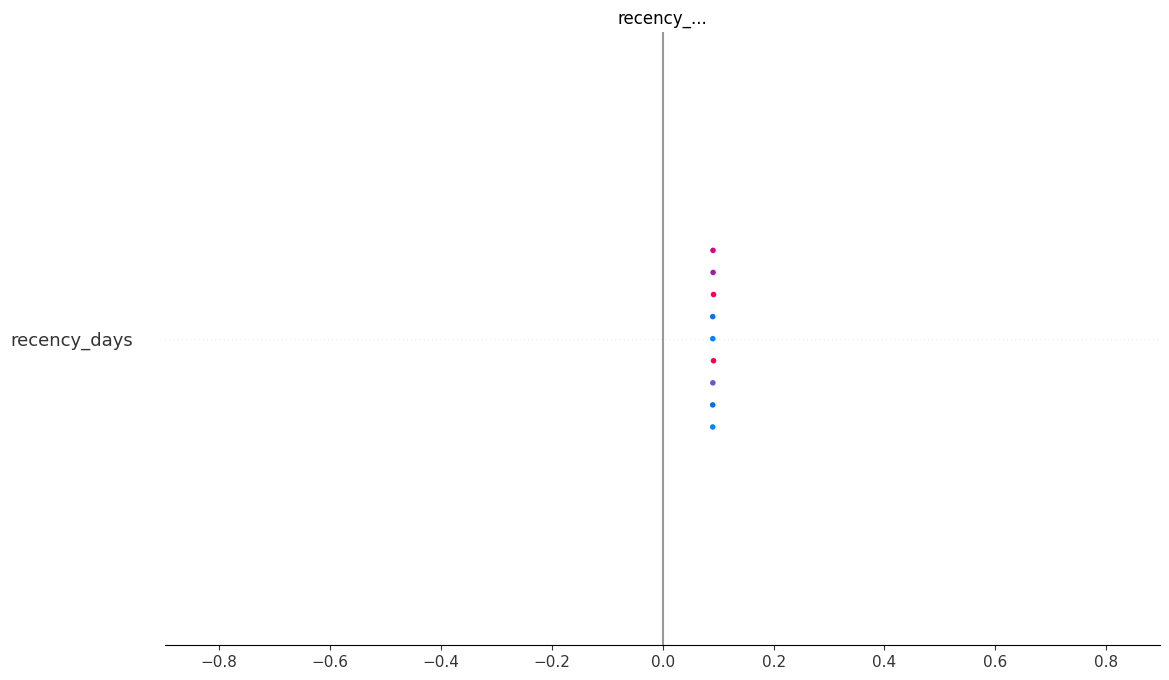

In [12]:
import shap

explainer = shap.KernelExplainer(
    model=lambda x: model_cnn.predict([np.zeros((x.shape[0], 12, 1)), x]),  # fix sequence to zeros
    data=X_test_static[:100]  # background dataset for SHAP
)

# Compute SHAP values for static input features
shap_values = explainer.shap_values(X_test_static[:10])  # explain first 10 predictions

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_static[:10], feature_names=static_feats)


# LIME Explanations for CNN Model

In [14]:
import lime
import lime.lime_tabular
import numpy as np

# Use static features only for LIME (since LIME is tabular-focused)
X_for_lime = X_test_static  # shape: (N, num_features)
feature_names = static_feats

# Create the explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_static,
    feature_names=feature_names,
    class_names=['Not Churn', 'Churn'],
    mode='classification',
    discretize_continuous=True
)

# Wrapper for LIME: model outputs shape (N,) or (N,1), convert to (N,2)
def cnn_predict_proba(X_input):
    seq_zeros = np.zeros((X_input.shape[0], seq_length, 1))  # dummy sequence
    probs = model_cnn.predict([seq_zeros, X_input])  # (N,1)
    probs = probs.flatten()
    return np.vstack([1 - probs, probs]).T  # (N,2)

# Pick one test instance (e.g., high churn probability)
idx = np.argmax(y_pred_cnn)  # customer most likely to churn
instance = X_test_static[idx]

# Explain this prediction
lime_exp = lime_explainer.explain_instance(
    data_row=instance,
    predict_fn=cnn_predict_proba,
    num_features=7  # you can increase if needed
)

# Show explanation
lime_exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


# Get Churn Probabilities (CNN Model)

In [16]:
from sklearn.model_selection import train_test_split

customer_ids_all = customer_features['Customer ID'].values
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(y)), test_size=0.2, stratify=y, random_state=42
)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

n_static = len(static_feats)
seq_length = len(seq_feats)

X_train_seq = X_train_res[:, n_static:].reshape(-1, seq_length, 1)
X_train_static = X_train_res[:, :n_static]
X_test_seq = X_test[:, n_static:].reshape(-1, seq_length, 1)
X_test_static = X_test[:, :n_static]

y_pred_probs = model_cnn.predict([X_test_seq, X_test_static]).flatten()
y_pred_labels = (y_pred_probs >= 0.5).astype(int)
customer_ids = customer_ids_all[idx_test]

retention_df = pd.DataFrame({
    'Customer ID': customer_ids,
    'Churn Probability': y_pred_probs,
    'Churn Prediction': y_pred_labels
}).sort_values(by='Churn Probability', ascending=False)

retention_df.head(10)


10271/10271 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


Customer ID  Churn Probability  Churn Prediction
328661       875499                1.0                 1
0            950062                1.0                 1
1            742224                1.0                 1
2           1445442                1.0                 1
328660      1458326                1.0                 1
4           1137663                1.0                 1
5           1181033                1.0                 1
6            798375                1.0                 1
7           1242960                1.0                 1
8             39532                1.0                 1

In [17]:
# Attach relevant static features
retention_df = retention_df.merge(
    customer_features[['Customer ID', 'recency_days', 'avg_spend', 'discount_ratio', 'distinct_categories']],
    on='Customer ID',
    how='left'
)


In [18]:
def assign_strategy(row):
    if row['Churn Probability'] > 0.8:
        if row['avg_spend'] > 75:
            return 'Offer Loyalty Discount'
        elif row['discount_ratio'] > 0.5:
            return 'Trigger Timely Discount Notification'
        elif row['distinct_categories'] < 3:
            return 'Recommend Similar Categories'
        else:
            return 'Personalized Product Bundle'
    elif row['Churn Probability'] > 0.6:
        return 'Send Re-engagement Email'
    else:
        return 'No Action (Low Risk)'

retention_df['Retention Strategy'] = retention_df.apply(assign_strategy, axis=1)


In [19]:
# Show high-churn customers and their recommended strategies
actionable = retention_df[retention_df['Churn Probability'] > 0.6]
actionable = actionable.sort_values(by='Churn Probability', ascending=False)
actionable.head(10)  # sample top churn risks


Customer ID  Churn Probability  Churn Prediction  recency_days   avg_spend  discount_ratio  distinct_categories                    Retention Strategy
295720        86259                1.0                 1            83   37.333333        0.666667                  2.0  Trigger Timely Discount Notification
295721        41120                1.0                 1           124   47.166667        0.333333                  2.0          Recommend Similar Categories
295722       737765                1.0                 1           550   45.500000        0.000000                  1.0          Recommend Similar Categories
295723      1583743                1.0                 1           182   35.425000        0.000000                  2.0          Recommend Similar Categories
295724       242283                1.0                 1            87   53.653846        0.384615                  3.0           Personalized Product Bundle
295725        98231                1.0                 1           362   39.333333        0.166667                  3.0           Personalized Product Bundle
295726       506112                1.0                 1            49  313.875000        0.125000                  3.0                Offer Loyalty Discount
295727       314973                1.0                 1           809    0.000000        0.000000                  NaN           Personalized Product Bundle
295712      1109889                1.0                 1           449   52.750000        1.000000                  2.0  Trigger Timely Discount Notification
295713       202923                1.0                 1           295   75.000000        0.000000                  1.0          Recommend Similar Categories

In [22]:
# Redo train-test split with index tracking
X = customer_features[static_feats + seq_feats].fillna(0).values
y = customer_features['churn_label'].values

# Keep original DataFrame index to map later
indices = np.arange(len(y))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, stratify=y, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Extract and reshape static and sequence features
n_static = len(static_feats)
n_seq = len(seq_feats)
X_train_seq = X_train_res[:, n_static:].reshape(-1, n_seq, 1)
X_train_static = X_train_res[:, :n_static]
X_test_seq = X_test[:, n_static:].reshape(-1, n_seq, 1)
X_test_static = X_test[:, :n_static]

# Make predictions
y_pred_cnn = model_cnn.predict([X_test_seq, X_test_static]).flatten()
y_pred_cnn_label = (y_pred_cnn >= 0.5).astype(int)

# Build retention DataFrame
retention_df = pd.DataFrame({
    'Customer ID': customer_features.iloc[idx_test]['Customer ID'].values,
    'Churn Prediction': y_pred_cnn_label,
    'Churn Probability': y_pred_cnn
})

# Merge with original features
retention_full = pd.merge(retention_df, customer_features, on='Customer ID', how='left')

# Apply retention strategy
def assign_retention_action(row):
    if row['Churn Prediction'] == 0:
        return 'No action needed'
    if row['avg_spend'] > 80 and row['purchase_count'] > 10:
        return 'Offer premium discount (20%) + exclusive product bundle'
    elif row['avg_spend'] > 40:
        return 'Send 10% discount voucher + restock alert for favorites'
    elif row['discount_ratio'] > 0.5:
        return 'Send loyalty reminder + targeted promotions'
    elif row['recency_days'] > 90:
        return 'Reactivate with email campaign and re-engagement offer'
    else:
        return 'Generic 5% discount + personalized product recommendations'

retention_full['Retention Action'] = retention_full.apply(assign_retention_action, axis=1)

# Display results
top_churners = retention_full[retention_full['Churn Prediction'] == 1][
    ['Customer ID', 'Churn Probability', 'avg_spend', 'purchase_count',
     'discount_ratio', 'recency_days', 'Retention Action']
].sort_values(by='Churn Probability', ascending=False)

display(top_churners.head(10))


10271/10271 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


Customer ID  Churn Probability  avg_spend  purchase_count  discount_ratio  recency_days                                   Retention Action
328661       875499                1.0  14.350000             1.0        0.000000            71  Generic 5% discount + personalized product rec...
0            950062                1.0  30.833333             3.0        0.333333           447  Reactivate with email campaign and re-engageme...
1            742224                1.0  46.366667             6.0        0.666667            80  Send 10% discount voucher + restock alert for ...
2           1445442                1.0   0.000000             NaN        0.000000           809  Reactivate with email campaign and re-engageme...
4           1137663                1.0  77.850000             2.0        0.000000           612  Send 10% discount voucher + restock alert for ...
5           1181033                1.0   0.000000             NaN        0.000000           809  Reactivate with email campaign and re-engageme...
6            798375                1.0  42.891667             6.0        0.333333           170  Send 10% discount voucher + restock alert for ...
7           1242960                1.0  37.375000             4.0        0.500000           310  Reactivate with email campaign and re-engageme...
8             39532                1.0  59.730769            13.0        0.384615           187  Send 10% discount voucher + restock alert for ...
9            309992                1.0  44.437500             8.0        0.000000            91  Send 10% discount voucher + restock alert for ...

# SHAP on a Broader Sample (100–200 Customers)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
394/394 ━━━━━━

<ipython-input-23-ab49da530c66>:17: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_explain, feature_names=static_feats)
/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:726: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

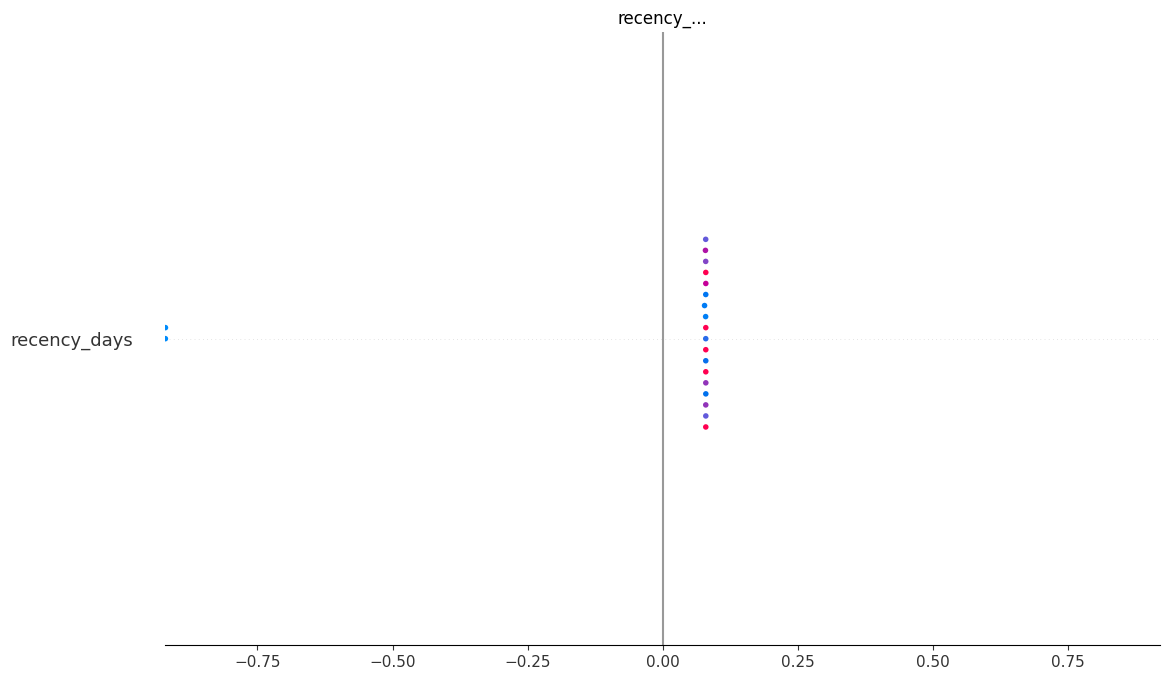

In [23]:
import shap

# Broader background and explanation sample
X_background = X_test_static[np.random.choice(X_test_static.shape[0], 100, replace=False)]
X_explain = X_test_static[np.random.choice(X_test_static.shape[0], 20, replace=False)]  # explain more instances

# Kernel SHAP with dummy sequence input (fix seq as zeros)
explainer = shap.KernelExplainer(
    model=lambda x: model_cnn.predict([np.zeros((x.shape[0], seq_length, 1)), x]),
    data=X_background
)

# Compute SHAP values (this will take a few minutes for 20 instances)
shap_values = explainer.shap_values(X_explain)

# Plot summary
shap.summary_plot(shap_values, X_explain, feature_names=static_feats)


# SHAP Interaction Values (Feature Pair Effects)

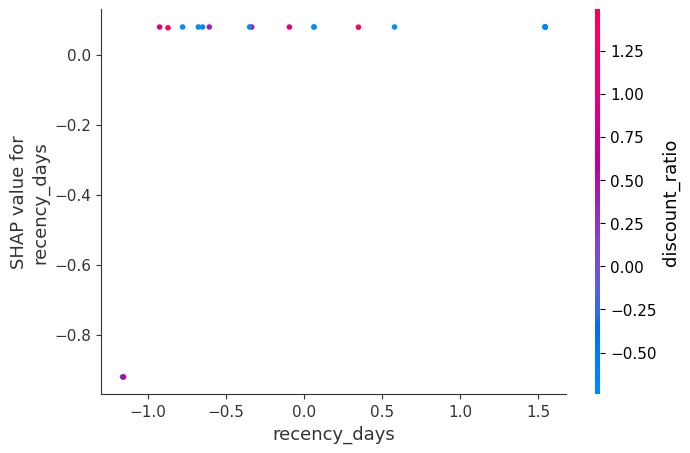

In [25]:
shap.dependence_plot(
    ind='recency_days',  # the feature to plot SHAP values for
    shap_values=shap_values,  # from regular SHAP explainer
    features=X_explain,
    feature_names=static_feats,
    interaction_index='discount_ratio'  # second feature to color by (possible interaction)
)


# LIME Explanation for Both a Churner and a Non-Churner

In [26]:
import lime.lime_tabular

# Reuse LIME explainer
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_static,
    feature_names=static_feats,
    class_names=['Not Churn', 'Churn'],
    mode='classification',
    discretize_continuous=True
)

# Prediction function wrapper
def cnn_predict_proba(X_input):
    seq_zeros = np.zeros((X_input.shape[0], seq_length, 1))
    probs = model_cnn.predict([seq_zeros, X_input]).flatten()
    return np.vstack([1 - probs, probs]).T

# Explain a churner (label == 1)
churner_idx = np.where((y_pred_cnn_label == 1) & (y_test == 1))[0][0]
lime_exp_churner = lime_explainer.explain_instance(
    data_row=X_test_static[churner_idx],
    predict_fn=cnn_predict_proba,
    num_features=7
)
lime_exp_churner.show_in_notebook()

# Explain a non-churner (label == 0)
non_churner_idx = np.where((y_pred_cnn_label == 0) & (y_test == 0))[0][0]
lime_exp_nonchurner = lime_explainer.explain_instance(
    data_row=X_test_static[non_churner_idx],
    predict_fn=cnn_predict_proba,
    num_features=7
)
lime_exp_nonchurner.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
